This project is taken from datacamp website, where the basics are explained in great detail. What I have added here is further explanation of the code, and then some advanced models to make predictions more accurate.

## 1. Preparing our dataset
<p><em>These recommendations are so on point! How does this playlist know me so well?</em></p>
<p><img src="https://s3.amazonaws.com/assets.datacamp.com/production/project_449/img/iphone_music.jpg" alt="Project Image Record" width="600px"></p>
<p>Over the past few years, streaming services with huge catalogs have become the primary means through which most people listen to their favorite music. But at the same time, the sheer amount of music on offer can mean users might be a bit overwhelmed when trying to look for newer music that suits their tastes.</p>
<p>For this reason, streaming services have looked into means of categorizing music to allow for personalized recommendations. One method involves direct analysis of the raw audio information in a given song, scoring the raw data on a variety of metrics. Today, we'll be examining data compiled by a research group known as The Echo Nest. Our goal is to look through this dataset and classify songs as being either 'Hip-Hop' or 'Rock' - all without listening to a single one ourselves. In doing so, we will learn how to clean our data, do some exploratory data visualization, and use feature reduction towards the goal of feeding our data through some simple machine learning algorithms, such as decision trees and logistic regression.</p>
<p>To begin with, let's load the metadata about our tracks alongside the track metrics compiled by The Echo Nest. A song is about more than its title, artist, and number of listens. We have another dataset that has musical features of each track such as <code>danceability</code> and <code>acousticness</code> on a scale from -1 to 1. These exist in two different files, which are in different formats - CSV and JSON. While CSV is a popular file format for denoting tabular data, JSON is another common file format in which databases often return the results of a given query.</p>
<p>Let's start by creating two pandas <code>DataFrames</code> out of these files that we can merge so we have features and labels (often also referred to as <code>X</code> and <code>y</code>) for the classification later on.</p>

In [2]:
import pandas as pd

# Read in track metadata with genre labels
tracks = pd.read_csv("fma-rock-vs-hiphop.csv")

# Read in track metrics with the features
echonest_metrics = pd.read_json("echonest-metrics.json", precise_float = True)

# Merge the relevant columns of tracks and echonest_metrics
echo_tracks = pd.merge(echonest_metrics, tracks[["track_id", "genre_top"]], on="track_id")

#Here, we are merging two datasets- echonest_metrics and tracks, but we are retaining only two columns from tracks dataset - track_id and genre_top.
#We are merging the dataset based on track_id

# Inspect the resultant dataframe
echo_tracks.info()
echo_tracks.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4802 entries, 0 to 4801
Data columns (total 10 columns):
track_id            4802 non-null int64
acousticness        4802 non-null float64
danceability        4802 non-null float64
energy              4802 non-null float64
instrumentalness    4802 non-null float64
liveness            4802 non-null float64
speechiness         4802 non-null float64
tempo               4802 non-null float64
valence             4802 non-null float64
genre_top           4802 non-null object
dtypes: float64(8), int64(1), object(1)
memory usage: 412.7+ KB


,track_id,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence
count,4802.000000,4.802000e+03,4802.000000,4802.000000,4802.000000,4802.000000,4802.000000,4802.000000,4802.000000
mean,30164.871720,4.870600e-01,0.436556,0.625126,0.604096,0.187997,0.104877,126.687944,0.453413
std,28592.013796,3.681396e-01,0.183502,0.244051,0.376487,0.150562,0.145934,34.002473,0.266632
min,2.000000,9.491000e-07,0.051307,0.000279,0.000000,0.025297,0.023234,29.093000,0.014392
25%,7494.250000,8.351236e-02,0.296047,0.450757,0.164972,0.104052,0.036897,98.000750,0.224617
50%,20723.500000,5.156888e-01,0.419447,0.648374,0.808752,0.123080,0.049594,124.625500,0.446240
75%,44240.750000,8.555765e-01,0.565339,0.837016,0.915472,0.215151,0.088290,151.450000,0.666914
max,124722.000000,9.957965e-01,0.961871,0.999768,0.993134,0.971392,0.966177,250.059000,0.983649


precise_float is a parameter set to enable usage of higher precision (strtod) function when decoding string to double values. Default (False) is to use fast but less precise builtin functionality. For better understanding, here is a great article demonstrating the strtod function. (https://www.geeksforgeeks.org/strtod-function-in-c-c/)

## 2. Pairwise relationships between continuous variables
<p>We typically want to avoid using variables that have strong correlations with each other -- hence avoiding feature redundancy -- for a few reasons:</p>
<ul>
<li>To keep the model simple and improve interpretability (with many features, we run the risk of overfitting).</li>
<li>When our datasets are very large, using fewer features can drastically speed up our computation time.</li>
</ul>
<p>To get a sense of whether there are any strongly correlated features in our data, we will use built-in functions in the <code>pandas</code> package.</p>

In [3]:
# Create a correlation matrix
corr_metrics = echo_tracks.corr()
corr_metrics.style.background_gradient()

,track_id,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence
track_id,1,-0.372282,0.0494541,0.140703,-0.275623,0.0482307,-0.0269951,-0.0253918,0.0100698
acousticness,-0.372282,1,-0.0289537,-0.281619,0.19478,-0.0199914,0.072204,-0.0263097,-0.0138406
danceability,0.0494541,-0.0289537,1,-0.242032,-0.255217,-0.106584,0.276206,-0.242089,0.473165
energy,0.140703,-0.281619,-0.242032,1,0.0282377,0.113331,-0.109983,0.195227,0.0386027
instrumentalness,-0.275623,0.19478,-0.255217,0.0282377,1,-0.0910218,-0.366762,0.022215,-0.219967
liveness,0.0482307,-0.0199914,-0.106584,0.113331,-0.0910218,1,0.0411725,0.00273169,-0.0450931
speechiness,-0.0269951,0.072204,0.276206,-0.109983,-0.366762,0.0411725,1,0.00824055,0.149894
tempo,-0.0253918,-0.0263097,-0.242089,0.195227,0.022215,0.00273169,0.00824055,1,0.0522212
valence,0.0100698,-0.0138406,0.473165,0.0386027,-0.219967,-0.0450931,0.149894,0.0522212,1


Put in plain terms, correlation is a measure of how strongly one variable depends on another.

Correlation can be an important tool for feature engineering in building machine learning models. Predictors which are uncorrelated with the objective variable are probably good candidates to trim from the model (shoe size is not a useful predictor for salary). In addition, if two predictors are strongly correlated to each other, then we only need to use one of them (in predicting salary, there is no need to use both age in years, and age in months). Taking these steps means that the resulting model will be simpler, and simpler models are easier to interpret.

Refer to this great article (https://blog.bigml.com/2015/09/21/looking-for-connections-in-your-data-correlation-coefficients/) for further explanation on correlation.

## 3. Normalizing the feature data
<p>As mentioned earlier, it can be particularly useful to simplify our models and use as few features as necessary to achieve the best result. Since we didn't find any particular strong correlations between our features, we can instead use a common approach to reduce the number of features called <strong>principal component analysis (PCA)</strong>. </p>

Principal component analysis (PCA) is a statistical procedure that uses an orthogonal transformation to convert a set of observations of possibly correlated variables (entities each of which takes on various numerical values) into a set of values of linearly uncorrelated variables called principal components.

Here is a very nice video explaining PCA in detail (https://www.youtube.com/watch?v=FgakZw6K1QQ&vl=en).

<p>It is possible that the variance between genres can be explained by just a few features in the dataset. PCA rotates the data along the axis of highest variance, thus allowing us to determine the relative contribution of each feature of our data towards the variance between classes. </p>
<p>However, since PCA uses the absolute variance of a feature to rotate the data, a feature with a broader range of values will overpower and bias the algorithm relative to the other features. To avoid this, we must first normalize our data. There are a few methods to do this, but a common way is through <em>standardization</em>, such that all features have a mean = 0 and standard deviation = 1 (the resultant is a z-score).</p>

In [4]:
# Define our features 
features = echo_tracks.drop(["genre_top","track_id"], axis=1)

# Define our labels
labels = echo_tracks["genre_top"]

# Import the StandardScaler
from sklearn.preprocessing import StandardScaler

# Scale the features and set the values to a new variable
scaler = StandardScaler()
scaled_train_features = scaler.fit_transform(features)

## 4. Principal Component Analysis on our scaled data
<p>Now that we have preprocessed our data, we are ready to use PCA to determine by how much we can reduce the dimensionality of our data. We can use <strong>scree-plots</strong> and <strong>cumulative explained ratio plots</strong> to find the number of components to use in further analyses.</p>
<p>Scree-plots display the number of components against the variance explained by each component, sorted in descending order of variance. Scree-plots help us get a better sense of which components explain a sufficient amount of variance in our data. When using scree plots, an 'elbow' (a steep drop from one data point to the next) in the plot is typically used to decide on an appropriate cutoff.</p>

[0.24297674 0.18044316 0.13650309 0.12994089 0.11056248 0.08302245
 0.06923783 0.04731336]
8


Text(0.5, 0, 'Principal Component #')

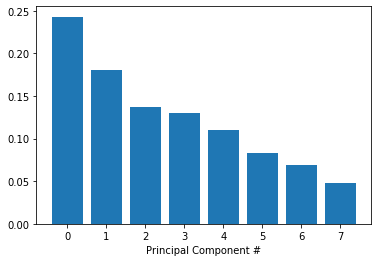

In [5]:
# This is just to make plots appear in the notebook
%matplotlib inline

# Import our plotting module, and PCA class
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Get our explained variance ratios from PCA using all features
pca = PCA()
pca.fit(scaled_train_features)
exp_variance = pca.explained_variance_ratio_

print(pca.explained_variance_ratio_)
print(pca.n_components_)

# plot the explained variance using a barplot
fig, ax = plt.subplots()
ax.bar(range(8), exp_variance)
ax.set_xlabel('Principal Component #')

## 5. Further visualization of PCA
<p>Unfortunately, there does not appear to be a clear elbow in this scree plot, which means it is not straightforward to find the number of intrinsic dimensions using this method. </p>
<p>But all is not lost! Instead, we can also look at the <strong>cumulative explained variance plot</strong> to determine how many features are required to explain, say, about 90% of the variance (cutoffs are somewhat arbitrary here, and usually decided upon by 'rules of thumb'). Once we determine the appropriate number of components, we can perform PCA with that many components, ideally reducing the dimensionality of our data.</p>

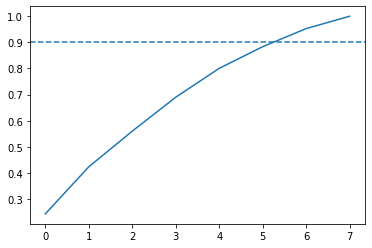

In [6]:
# Import numpy
import numpy as np

# Calculate the cumulative explained variance
cum_exp_variance = np.cumsum(exp_variance)

# Plot the cumulative explained variance and draw a dashed line at 0.90.
fig, ax = plt.subplots()
ax.plot(range(8), cum_exp_variance)
ax.axhline(y=0.9, linestyle='--')
n_components = 6

# Perform PCA with the chosen number of components and project data onto components
pca = PCA(n_components, random_state=10)
pca.fit(scaled_train_features)
pca_projection = pca.transform(scaled_train_features)

## 6. Balance our data for greater performance
<p>Both our models do similarly well, boasting an average precision of 87% each. However, looking at our classification report, we can see that rock songs are fairly well classified, but hip-hop songs are disproportionately misclassified as rock songs. </p>
<p>Why might this be the case? Well, just by looking at the number of data points we have for each class, we see that we have far more data points for the rock classification than for hip-hop, potentially skewing our model's ability to distinguish between classes. This also tells us that most of our model's accuracy is driven by its ability to classify just rock songs, which is less than ideal.</p>
<p>To account for this, we can weight the value of a correct classification in each class inversely to the occurrence of data points for each class. Since a correct classification for "Rock" is not more important than a correct classification for "Hip-Hop" (and vice versa), we only need to account for differences in <em>sample size</em> of our data points when weighting our classes here, and not relative importance of each class. </p>

In [7]:
# Subset only the hip-hop tracks, and then only the rock tracks
hop_only = echo_tracks.loc[echo_tracks["genre_top"] == "Hip-Hop"]
rock_only = echo_tracks.loc[echo_tracks["genre_top"] == "Rock"]

# sample the rocks songs to be the same number as there are hip-hop songs
rock_only = rock_only.sample(len(hop_only), random_state=10)

# concatenate the dataframes rock_only and hop_only
rock_hop_bal = pd.concat([rock_only, hop_only])

# The features, labels, and pca projection are created for the balanced dataframe
features = rock_hop_bal.drop(['genre_top', 'track_id'], axis=1) 
labels = rock_hop_bal['genre_top']
pca_projection = pca.fit_transform(scaler.fit_transform(features))

# Import train_test_split function and Decision tree classifier
from sklearn.model_selection import train_test_split

# Define the train and test set with the pca_projection from the balanced data
train_features, test_features, train_labels, test_labels = train_test_split(pca_projection, labels, random_state=10)

## 7. Understanding the Evaluation Metrics

Before we move onto the algorithms, it is crucial to understand the metric we are going to use to evaluate our predictive models.

Accuracy - Accuracy is the most intuitive performance measure and it is simply a ratio of correctly predicted observation to the total observations. One may think that, if we have high accuracy then our model is best. Yes, accuracy is a great measure but only when you have symmetric datasets where values of false positive and false negatives are almost same. Therefore, you have to look at other parameters to evaluate the performance of your model. For our model, we have got 0.803 which means our model is approx. 80% accurate.

Accuracy = TP+TN/TP+FP+FN+TN

Precision - Precision is the ratio of correctly predicted positive observations to the total predicted positive observations. The question that this metric answer is of all passengers that labeled as survived, how many actually survived? High precision relates to the low false positive rate. We have got 0.788 precision which is pretty good.

Precision = TP/TP+FP

Recall (Sensitivity) - Recall is the ratio of correctly predicted positive observations to the all observations in actual class - yes. The question recall answers is: Of all the passengers that truly survived, how many did we label? We have got recall of 0.631 which is good for this model as it’s above 0.5.

Recall = TP/TP+FN

F1 score - F1 Score is the weighted average of Precision and Recall. Therefore, this score takes both false positives and false negatives into account. Intuitively it is not as easy to understand as accuracy, but F1 is usually more useful than accuracy, especially if you have an uneven class distribution. Accuracy works best if false positives and false negatives have similar cost. If the cost of false positives and false negatives are very different, it’s better to look at both Precision and Recall. In our case, F1 score is 0.701.

F1 Score = 2*(Recall * Precision) / (Recall + Precision)

As you may have got an idea, the evaluation metric that we are going to use is Accuracy. The evaluation metric depends on the type of data that you are analyzing. If we were handling a sensitive problem (like cancer test, loan application) then false positives matter a lot. But, we are only dealing with songs, and no one label is more crucia or sensitive than the other. Hence, accuracy is what we will be more concerned with.

## 8. Applying the Algorithms

This is the part where we start creating different predictive models and evaluate them for their accuracy. I'll also breifly mention the mathematics behind the model and provide reference for further information.

### 8.1 KNN

In [9]:
# Create the classification report for all the models we shall use
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier


#Importing a package to fine-tune and optimize our algorithms
from sklearn.model_selection import GridSearchCV
knn_grid_params = {
    'n_neighbors': [1,2,3,4,5,6,7],
    'weights': ['uniform','distance'],
    'metric': ['euclidean','manhattan']
}
knn_gs = GridSearchCV(KNeighborsClassifier(),knn_grid_params,verbose=1, n_jobs = -1)
knn_gs_results = knn_gs.fit(train_features, train_labels)
print("Accuracy of the KNN model is: ", knn_gs_results.best_score_)
print("KNN model best parameters are: ", knn_gs_results.best_params_)

C:\Users\ajink\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 28 candidates, totalling 84 fits
Accuracy of the KNN model is:  0.832967032967033
KNN model best parameters are:  {'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  84 out of  84 | elapsed:    2.3s finished


K nearest neighbors is a simple algorithm that stores all available cases and classifies new cases based on a similarity measure (e.g., distance functions).

Reference: https://medium.com/@erikgreenj/k-neighbors-classifier-with-gridsearchcv-basics-3c445ddeb657

### 8.2 Logistic Regression 

In [20]:
# Train our logistic regression on the balanced data
from sklearn.linear_model import LogisticRegression
logit_grid_params = {
    'C':[0.001,0.1,1,10,100],
    'penalty':['l1','l2','elasticnet'],
    'solver':['saga'],
    'l1_ratio':[0,0.1,0.5,0.7,1]
}
logit_gs = GridSearchCV(LogisticRegression(),logit_grid_params,verbose=1, n_jobs = -1)
logit_gs_results = logit_gs.fit(train_features, train_labels)
print("Accuracy of the Logistic Regression model is: ", logit_gs_results.best_score_)
print("Logistic Regression model best parameters are: ", logit_gs_results.best_params_)

C:\Users\ajink\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 75 candidates, totalling 225 fits


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 225 out of 225 | elapsed:    2.4s finished


Accuracy of the Logistic Regression model is:  0.8161172161172161
Logistic Regression model best parameters are:  {'C': 10, 'l1_ratio': 0, 'penalty': 'l2', 'solver': 'saga'}


C:\Users\ajink\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1506: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))


I am not quite sure about the parameters used in this algorithm. I am researching on it to find exactly what does each parameter specify and how it affects the predictive capabilities of the model.

### 8.3 Decision Trees

In [34]:
# Train our decision tree on the balanced data
from sklearn.tree import DecisionTreeClassifier
tree_grid_params = {
    'criterion': ['gini','entropy'],
    'min_samples_split': [2,3,4,5,6,7,8,9,10],
    'min_samples_leaf' : [1,2,3,4],
}
tree_gs = GridSearchCV(DecisionTreeClassifier(),tree_grid_params,verbose=1, n_jobs = -1)
tree_gs_results = tree_gs.fit(train_features, train_labels)
print("Accuracy of the Decision Tree Classifier model is: ", tree_gs_results.best_score_)
print("Decision Tree Classifier model best parameters are: ", tree_gs_results.best_params_)


C:\Users\ajink\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 72 candidates, totalling 216 fits


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.2s


Accuracy of the Decision Tree Classifier model is:  0.7743589743589744
Decision Tree Classifier model best parameters are:  {'criterion': 'entropy', 'min_samples_leaf': 4, 'min_samples_split': 10}


[Parallel(n_jobs=-1)]: Done 216 out of 216 | elapsed:    2.4s finished


As we can see, decision tree classifier gives us a very low accuracy. The best from the models we evaluated so far is the KNN.

### 8.4 Random Forest

In [42]:
# Train our random forest on the balanced data
from sklearn.ensemble import RandomForestClassifier
rf_grid_params = {
    'n_estimators': [60,70,80,90,100],
    'criterion': ['gini','entropy']
}
rf_gs = GridSearchCV(RandomForestClassifier(),rf_grid_params,verbose=1, n_jobs = -1)
rf_gs_results = rf_gs.fit(train_features, train_labels)
print("Accuracy of the Random Forest Classifier model is: ", rf_gs_results.best_score_)
print("Random Forest Classifier model best parameters are: ", rf_gs_results.best_params_)


C:\Users\ajink\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  30 | elapsed:    0.1s remaining:    0.5s


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.6s finished


Accuracy of the Random Forest Classifier model is:  0.8344322344322345
Random Forest Classifier model best parameters are:  {'criterion': 'entropy', 'n_estimators': 100}


### 8.5 xG boost

In [49]:
# Train our XG Boost model on the balanced data
from sklearn.ensemble import GradientBoostingClassifier
gb_grid_params = {
    'loss': ['deviance','exponential'],
    'learning_rate': [0.01,0.04,0.1,0.2,0.5],
    'n_estimators': [60,70,80,90,100],
    'warm_start': ['True','False']
}
gb_gs = GridSearchCV(GradientBoostingClassifier(),gb_grid_params,verbose=1, n_jobs = -1)
gb_gs_results = gb_gs.fit(train_features, train_labels)
print("Accuracy of the Gradient Boosting Classifier model is: ", gb_gs_results.best_score_)
print("Gradient Boosting Classifier model best parameters are: ", gb_gs_results.best_params_)

C:\Users\ajink\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   22.5s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   26.1s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   28.9s finished


Accuracy of the Gradient Boosting Classifier model is:  0.8234432234432234
Gradient Boosting Classifier model best parameters are:  {'learning_rate': 0.5, 'loss': 'exponential', 'n_estimators': 100, 'warm_start': 'True'}


### 8.6 Support Vector Machine

In [52]:
# Train our SVM model on the balanced data
from sklearn.svm import SVC
svc_grid_params = {
    'C':[0.001,0.1,1,10,100],
    'degree':[1,2,3,4,5],
    }
svc_gs = GridSearchCV(SVC(),svc_grid_params,verbose=1, n_jobs = -1)
svc_gs_results = svc_gs.fit(train_features, train_labels)
print("Accuracy of the SVC model is: ", svc_gs_results.best_score_)
print("SVC model best parameters are: ", svc_gs_results.best_params_)

C:\Users\ajink\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    5.9s


Accuracy of the SVC model is:  0.8395604395604396
SVC model best parameters are:  {'C': 1, 'degree': 1}


[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    6.4s finished
C:\Users\ajink\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


### 8.7 Neural Networks

In [56]:
# Train our neural network model on balanced data
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(100,100,100), max_iter=500, alpha=0.0001,
                     solver='sgd', verbose=10,  random_state=21,tol=0.000000001)
mlp_results = mlp.fit(train_features, train_labels)
pred = mlp.predict(train_features)
accuracy_score(train_labels, pred)

Iteration 1, loss = 0.73463753
Iteration 2, loss = 0.72930827
Iteration 3, loss = 0.72178216
Iteration 4, loss = 0.71368715
Iteration 5, loss = 0.70534230
Iteration 6, loss = 0.69734020
Iteration 7, loss = 0.68940567
Iteration 8, loss = 0.68179058
Iteration 9, loss = 0.67444407
Iteration 10, loss = 0.66727419
Iteration 11, loss = 0.66016361
Iteration 12, loss = 0.65333306
Iteration 13, loss = 0.64666227
Iteration 14, loss = 0.63983817
Iteration 15, loss = 0.63321061
Iteration 16, loss = 0.62653774
Iteration 17, loss = 0.62002353
Iteration 18, loss = 0.61337436
Iteration 19, loss = 0.60685978
Iteration 20, loss = 0.60026066
Iteration 21, loss = 0.59376147
Iteration 22, loss = 0.58727203
Iteration 23, loss = 0.58068279
Iteration 24, loss = 0.57440092
Iteration 25, loss = 0.56793278
Iteration 26, loss = 0.56159590
Iteration 27, loss = 0.55518675
Iteration 28, loss = 0.54893490
Iteration 29, loss = 0.54261992
Iteration 30, loss = 0.53670881
Iteration 31, loss = 0.53062439
Iteration 32, los

C:\Users\ajink\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0.8622710622710623

I am not sure this is the best implementation of neural network model. I just tried to build a very basic model and I can already see it's not too efficient. But, the good thing is we now have a more accurate model, which means that neural network are a great tool to solve our problem. I plan to make a separate kernel to build a neural network model and fine-tune it to make it more efficient.